# 实例：随机森林在乳腺癌数据上的调参
本实例基于方差和偏差的调参方法，在乳腺癌数据上进行一次随机森林的调参。乳腺癌数据是sklearn自带的分类数据之一。

kaggle上的辨别手写数字的数据，有4W多条记录700多个左右的特征，随机森林在这个辨别手写数字的数据上有非常好的表现，其调参案例也是非常经典，但是由于数据的维度太高，太过复杂，运行一次完整的网格搜索需要四五个小时，因此不太可能拿来给大家进行演示。之前案例中用的泰坦尼克号数据，用来调参的话也是需要很长时间，因此才选择sklearn当中自带的，结构相对清晰简单的数据来做这个案例。感兴趣的话，可以直接到kaggle上进行下载，数据集名称是[Digit Recognizer](https://www.kaggle.com/c/digit-recognizer)。

## 1、导入需要的库

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

## 2、导入数据集，探索数据

In [8]:
data = load_breast_cancer()

In [17]:
pd.DataFrame(data.data).head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [18]:
data.data.shape

(569, 30)

In [19]:
 data.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

## 3、进行一次简单的建模，看看模型本身在数据集上的效果

In [27]:
rfc = RandomForestClassifier(random_state=10, n_estimators=100)
score_pre = cross_val_score(rfc, data.data, data.target, cv=10).mean()
score_pre

0.9650289516895688

## 4、随机森林调整的第一步：无论如何先来调n_estimators

在这里选择学习曲线，可以使用网格搜索吗？可以，但是只有学习曲线，才能看见趋势。

个人的倾向是，要看见n_estimators在什么取值开始变得平稳，是否一直推动模型整体准确率的上升等信息。

第一次的学习曲线，可以先用来帮助我们划定范围，我们取每十个数作为一个阶段，来观察n_estimators的变化如何
引起模型整体准确率的变化

0.9667854982283295 21


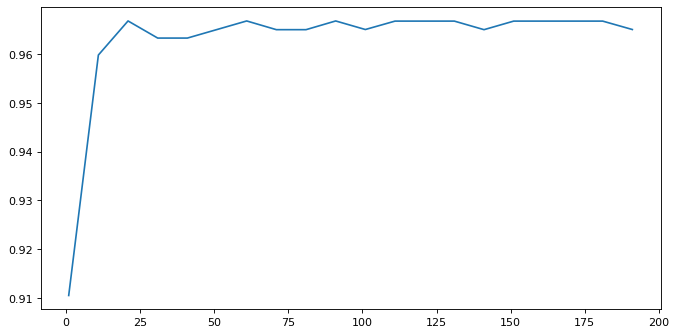

In [60]:
scorel = []
for i in range(0, 200, 10):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                n_jobs=-1,
                                random_state=10
                                )
    score = cross_val_score(rfc, data.data, data.target, cv=10).mean()
    scorel.append(score)
print(max(scorel), (scorel.index(max(scorel))*10) + 1)
plt.figure(figsize=(10,5),dpi=80)
plt.plot(range(1, 201, 10), scorel)
plt.show()

## 5、在确定好的范围内，进一步细化学习曲线

0.9667854982283295 20


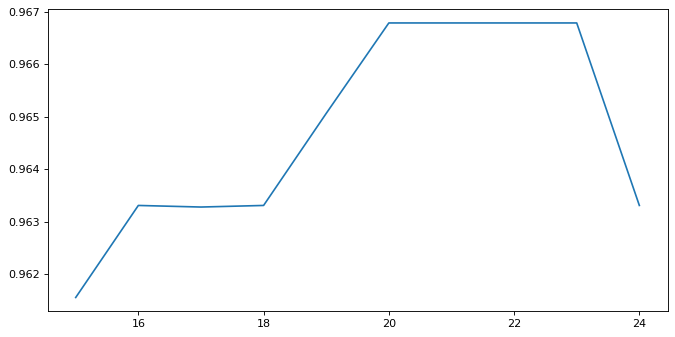

In [61]:
scorel = []
for i in range(15, 25):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                n_jobs=-1,
                                random_state=10
                                )
    score = cross_val_score(rfc, data.data, data.target, cv=10).mean()
    scorel.append(score)
print(max(scorel), [*range(15,25)][scorel.index(max(scorel))])
plt.figure(figsize=(10,5),dpi=80)
plt.plot(range(15,25), scorel)
plt.show()

调整n_estimators，模型的准确率立刻上升了0.0017。接下来就进入网格搜索，我们将使用网格搜索对
参数一个个进行调整。为什么我们不同时调整多个参数呢？原因有两个：
- 1）同时调整多个参数会运行非常缓慢。
- 2）同时调整多个参数，会让我们无法理解参数的组合是怎么得来的，所以即便网格搜索调出来的结果不好，我们也不知道从哪里去改。在这里，为了使用复杂度-泛化误差方法（方差-偏差方法），我们对参数进行一个个地调整。

## 6、为网格搜索做准备，书写网格搜索的参数

有一些参数是没有参照的，很难说清一个范围，这种情况下我们使用学习曲线，看趋势从曲线跑出的结果中选取一个更小的区间，再跑曲线

- `param_grid = {'n_estimators':np.arange(0, 200, 10)}`
- `param_grid = {'max_depth':np.arange(1, 20, 1)}`
    
- `param_grid = {'max_leaf_nodes':np.arange(25,50,1)}`

对于大型数据集，可以尝试从1000来构建，先输入1000，每100个叶子一个区间，再逐渐缩小范围
 
 有一些参数是可以找到一个范围的，或者说我们知道他们的取值和随着他们的取值，模型的整体准确率会如何变化，这样的参数我们就可以直接跑网格搜索
 
- `param_grid = {'criterion':['gini', 'entropy']}`
- `param_grid = {'min_samples_split':np.arange(2, 2+20, 1)}`
- `param_grid = {'min_samples_leaf':np.arange(1, 1+10, 1)}`

- `param_grid = {'max_features':np.arange(5,30,1)} `

## 7、开始按照参数对模型整体准确率的影响程度进行调参，首先调整max_depth

In [35]:
param_grid = {'max_depth': np.arange(1, 20, 1)}
# 一般根据数据的大小来进行一个试探，乳腺癌数据很小，所以可以采用1~10，或者1~20这样的试探
#  但对于像digit recognition那样的大型数据来说，我们应该尝试30~50层深度（或许还不足够
#  更应该画出学习曲线，来观察深度对模型的影响

rfc = RandomForestClassifier(n_estimators=20,
                            random_state=10)

GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(data.data, data.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max

In [36]:
GS.best_params_

{'max_depth': 9}

In [41]:
# 第一次简单训练分数：0.9650289516895688
# 调整了max_depth分数还下降了，说明模型现在处于最低点左边，不适合调max_depth
GS.best_score_

0.9648506151142355

在这里，我们注意到，将max_depth设置为有限之后，模型的准确率下降了。限制max_depth，是让模型变得简
单，把模型向左推，而模型整体的准确率下降了，即整体的泛化误差上升了，这说明模型现在位于图像左边，即泛
化误差最低点的左边（偏差为主导的一边）。通常来说，随机森林应该在泛化误差最低点的右边，树模型应该倾向
于过拟合，而不是拟合不足。这和数据集本身有关，但也有可能是我们调整的n_estimators对于数据集来说太大，
因此将模型拉到泛化误差最低点去了。然而，既然我们追求最低泛化误差，那我们就保留这个n_estimators，除非
有其他的因素，可以帮助我们达到更高的准确率。
当模型位于图像左边时，我们需要的是增加模型复杂度（增加方差，减少偏差）的选项，因此max_depth应该尽量
大，min_samples_leaf和min_samples_split都应该尽量小。这几乎是在说明，除了max_features，我们没有任何
参数可以调整了，因为max_depth，min_samples_leaf和min_samples_split是剪枝参数，是减小复杂度的参数。
在这里，我们可以预言，我们已经非常接近模型的上限，模型很可能没有办法再进步了。
那我们这就来调整一下max_features，看看模型如何变化。

## 8、调整max_features

max_features是唯一一个即能够将模型往左（低方差高偏差）推，也能够将模型往右（高方差低偏差）推的参数。我
们需要根据调参前，模型所在的位置（在泛化误差最低点的左边还是右边）来决定我们要将max_features往哪边调。
现在模型位于图像左侧，我们需要的是更高的复杂度，因此我们应该把max_features往更大的方向调整，可用的特征
越多，模型才会越复杂。max_features的默认最小值是sqrt(n_features)，因此我们使用这个值作为调参范围的
最小值。

In [42]:
param_grid = {"max_features": np.arange(5,30,1)}

rfc = RandomForestClassifier(n_estimators=20,
                            random_state=10)

GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(data.data, data.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max

In [43]:
GS.best_params_

{'max_features': 13}

In [47]:
# 又降低了
GS.best_score_

0.9666080843585237

网格搜索返回了max_features的最小值，可见max_features升高之后，模型的准确率降低了。这说明，我们把模
型往右推，模型的泛化误差增加了。前面用max_depth往左推，现在用max_features往右推，泛化误差都增加，
这说明模型本身已经处于泛化误差最低点，已经达到了模型的预测上限，没有参数可以左右的部分了。剩下的那些
误差，是噪声决定的，已经没有方差和偏差的舞台了。
如果是现实案例，我们到这一步其实就可以停下了，因为复杂度和泛化误差的关系已经告诉我们，模型不能再进步
了。调参和训练模型都需要很长的时间，明知道模型不能进步了还继续调整，不是一个有效率的做法。如果我们希
望模型更进一步，我们会选择更换算法，或者更换做数据预处理的方式。出于练习和探索的目的，我们继续调整我们的参数，让大家观察一下模型的变化，看看我们预测得是否正确。依然按照参数对模型整体准确率的影响程度进行调参。

## 9、调整min_samples_leaf

对于min_samples_split和min_samples_leaf,一般是从他们的最小值开始向上增加10或20

面对高维度高样本量数据，如果不放心，也可以直接+50，对于大型数据，可能需要200~300的范围

如果调整的时候发现准确率无论如何都上不来，那可以放心大胆调一个很大的数据，大力限制模型的复杂度

In [52]:
param_grid={'min_samples_leaf':np.arange(1, 1+10, 1)}

rfc = RandomForestClassifier(n_estimators=20
                             ,random_state=10
                           )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min

In [53]:
GS.best_params_

{'min_samples_leaf': 1}

In [54]:
GS.best_score_

0.9648506151142355

可以看见，网格搜索返回了min_samples_leaf的最小值，并且模型整体的准确率还降低了，这和max_depth的情
况一致，参数把模型向左推，但是模型的泛化误差上升了。在这种情况下，我们显然是不要把这个参数设置起来
的，就让它默认就好了。

## 10、不懈努力，继续尝试min_samples_split

In [56]:
param_grid={'min_samples_split':np.arange(2, 2+20, 1)}
rfc = RandomForestClassifier(n_estimators=20
                             ,random_state=10
                           )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min

In [57]:
GS.best_params_

{'min_samples_split': 5}

In [62]:
GS.best_score_

-0.00017741386980574259

和min_samples_leaf一样的结果，返回最小值并且模型整体的准确率降低了。

## 11、最后尝试一下criterion

In [79]:
param_grid = {'criterion':['gini', 'entropy']}
rfc = RandomForestClassifier(n_estimators=20
                             ,random_state=10
                           )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'cri

In [80]:
GS.best_params_

{'criterion': 'entropy'}

In [81]:
# 调整n_estimators后的分数：0.9650289516895688
# 提高了
GS.best_score_

0.968365553602812

## 12、调整完毕，总结出模型的最佳参数

好像调整random_state可以提高准确率，90的时候就比10高

In [83]:
rfc = RandomForestClassifier(n_estimators=20,random_state=10, criterion='entropy')
score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
# score
score - score_pre

0.0034796041828707436

在整个调参过程之中，我们首先调整了n_estimators（无论如何都请先走这一步），然后调整max_depth，通过
max_depth产生的结果，来判断模型位于复杂度-泛化误差图像的哪一边，从而选择我们应该调整的参数和调参的
方向。如果感到困惑，也可以画很多学习曲线来观察参数会如何影响我们的准确率，选取学习曲线中单调的部分来
放大研究（如同我们对n_estimators做的）。学习曲线的拐点也许就是我们一直在追求的，最佳复杂度对应的泛化
误差最低点（也是方差和偏差的平衡点）。

网格搜索也可以一起调整多个参数，大家只要有时间，可以自己跑一下，看看网格搜索会给我们怎样的结果，有时
候，它的结果比我们的好，有时候，我们手动调整的结果会比较好。当然了，我们的乳腺癌数据集非常完美，所以
只需要调n_estimators一个参数就达到了随机森林在这个数据集上表现得极限。